# 📊 Clutch Revenue: Predicción del Valor Comercial en la NBA

Este notebook está organizado en secciones para:

1. **Cargar y limpiar** los datos de partidos, jugadores y jugadas.
2. **Filtrar jugadas “clutch”** (últimos 5 minutos, periodo ≥ 4, marcador ±5).
3. **Explorar esas jugadas**: tipos de eventos, jugadores más activos, etc.
4. **Calcular métricas de tiro clutch**: tiros intentados, anotados, eficiencia.
5. **Visualizar** los resultados para storytelling.


In [96]:
# 3.1. Importar librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para mostrar gráficos inline si usas Jupyter:
%matplotlib inline

# 3.2. Ajustes de estilo (opcional)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)



Top 10 tiradores clutch (mínimo 10 intentos):


,player1_name,tiros_intentados,tiros_anotados,eficiencia
229,Caleb Martin,11,9,0.818
195,Brian Scalabrine,11,9,0.818
655,Grant Williams,11,9,0.818
1442,Ray McCallum,10,8,0.800
1163,Malik Allen,27,21,0.778
1280,Mikki Moore,26,20,0.769
1041,Kevin Knox II,13,10,0.769
277,Chris Anstey,13,10,0.769
172,Brandan Wright,21,16,0.762
626,Gary Payton II,12,9,0.750


/var/folders/sc/9fn1kvh90nq2n1t913qbts5w0000gq/T/ipykernel_30429/482026784.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


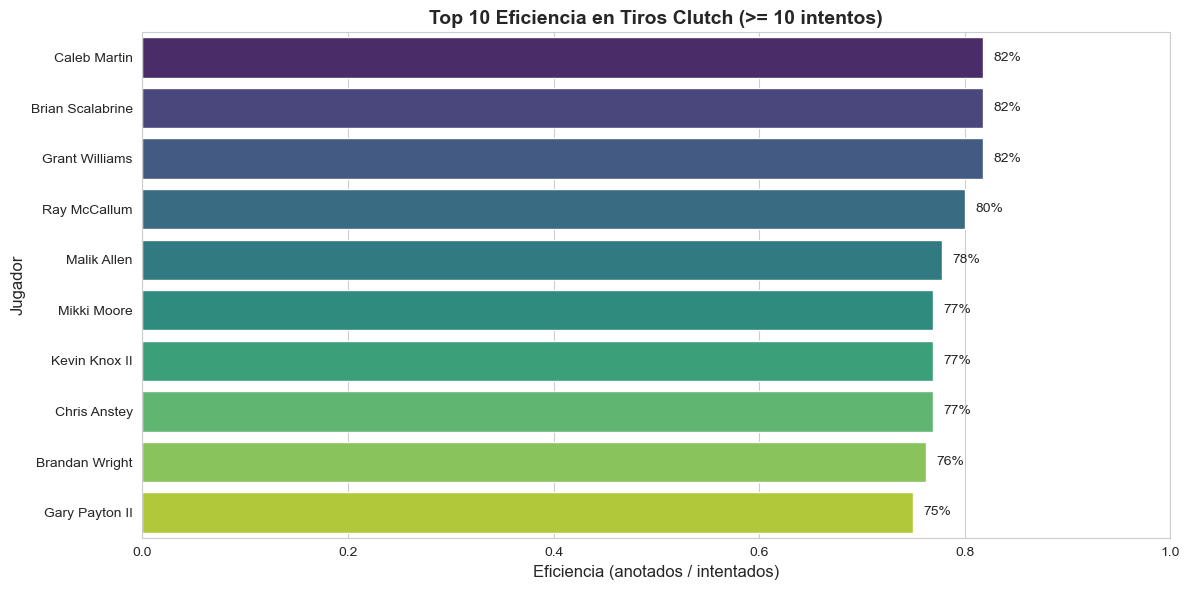

In [97]:
def plot_top_shooters(df_top_shooters, top_n=10):
    """
    Muestra un barplot con los top_n jugadores por eficiencia en tiros clutch.
    """
    topn = df_top_shooters.head(top_n)

    print(f"\nTop {top_n} tiradores clutch (mínimo 10 intentos):")
    display(topn[["player1_name", "tiros_intentados", "tiros_anotados", "eficiencia"]])

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="eficiencia",
        y="player1_name",
        data=topn,
        palette="viridis"
    )
    plt.title(f"Top {top_n} Eficiencia en Tiros Clutch (>= 10 intentos)", fontsize=14, fontweight="bold")
    plt.xlabel("Eficiencia (anotados / intentados)", fontsize=12)
    plt.ylabel("Jugador", fontsize=12)
    plt.xlim(0, 1)

    # Etiquetas con el porcentaje exacto al lado de cada barra
    for i, v in enumerate(topn["eficiencia"]):
        plt.text(v + 0.01, i, f"{v:.0%}", va="center")

    plt.tight_layout()
    plt.show()

# Uso:
plot_top_shooters(df_top_shooters, top_n=10)


In [98]:
# 4.1. Columnas y dtypes para play_by_play.csv
cols_plays = [
    "game_id",
    "eventmsgtype",
    "period",
    "pctimestring",
    "scoremargin",
    "player1_id",
    "player1_name",
    "homedescription",
    "visitordescription"
]

dtypes_plays = {
    "game_id": "Int32",
    "eventmsgtype": "UInt8",
    "period": "UInt8",
    "player1_id": "Int32",
    "player1_name": "object",
    "homedescription": "object",
    "visitordescription": "object"
}

# 4.2. Columnas y dtypes para game.csv
cols_games = [
    "game_id",
    "season_id",
    "game_date",
    "team_id_home",
    "team_id_away",
    "pts_home",
    "pts_away"
]

dtypes_games = {
    "game_id": "Int32",
    "season_id": "object",
    "team_id_home": "Int16",
    "team_id_away": "Int16",
    "pts_home": "Int16",
    "pts_away": "Int16"
}

# 4.3. Columnas y dtypes para player.csv
cols_players = ["id", "full_name", "first_name", "last_name", "is_active"]
dtypes_players = {
    "id": "Int32",
    "full_name": "object",
    "first_name": "object",
    "last_name": "object",
    "is_active": "boolean"
}

# 4.4. (Opcional) Columnas y dtypes para other_stats.csv si fuera necesario
cols_other = [
    "game_id",
    "team_id_home",
    "team_id_away",
    "pts_paint_home",
    "pts_paint_away",
    "team_turnovers_home",
    "team_turnovers_away",
    "team_rebounds_home",
    "team_rebounds_away"
]

dtypes_other = {
    "game_id": "Int32",
    "team_id_home": "Int16",
    "team_id_away": "Int16",
    "pts_paint_home": "Int16",
    "pts_paint_away": "Int16",
    "team_turnovers_home": "Int16",
    "team_turnovers_away": "Int16",
    "team_rebounds_home": "Int16",
    "team_rebounds_away": "Int16"
}


In [99]:
def cargar_partidos(path_game="game.csv"):
    """
    Lee game.csv y devuelve:
      - df_games: DataFrame completo con columnas definidas en cols_games.
      - dict_game_to_season: mapeo game_id → season_id.
    """
    try:
        df_games = pd.read_csv(
            path_game,
            usecols=cols_games,
            dtype=dtypes_games,
            parse_dates=["game_date"]
        )
        print(f"Cargados {len(df_games)} registros de partidos.")
    except Exception as e:
        print(f"Error al cargar {path_game}: {e}")
        df_games = pd.DataFrame(columns=cols_games)

    # Crear diccionario game_id → season_id
    if not df_games.empty:
        dict_game_to_season = df_games.set_index("game_id")["season_id"].to_dict()
    else:
        dict_game_to_season = {}

    return df_games, dict_game_to_season

# Uso:
df_games, game_to_season = cargar_partidos("game.csv")


Cargados 65698 registros de partidos.


In [100]:
def cargar_jugadores(path_player="player.csv"):
    """
    Lee player.csv y devuelve un DataFrame con info de jugadores.
    """
    try:
        df_players = pd.read_csv(
            path_player,
            usecols=cols_players,
            dtype=dtypes_players
        )
        print(f"Cargados {len(df_players)} jugadores.")
    except Exception as e:
        print(f"Error al cargar {path_player}: {e}")
        df_players = pd.DataFrame(columns=cols_players)

    return df_players

# Uso:
df_players = cargar_jugadores("player.csv")


Cargados 4831 jugadores.


In [ ]:
def procesar_jugadas_clutch(path_plays="play_by_play.csv", dict_game_to_season=None):
    """
    Recorre play_by_play.csv en chunks, calcula 'seconds_remaining',
    asigna 'season_id' y retorna un DataFrame con SOLO jugadas clutch:
      - period >= 4
      - seconds_remaining <= 300
      - abs(scoremargin) <= 5
    """
    df_clutch = pd.DataFrame(columns=cols_plays + ["seconds_remaining", "season_id"])

    try:
        chunk_iter = pd.read_csv(
            path_plays,
            usecols=cols_plays,
            dtype=dtypes_plays,
            chunksize=400_000
        )

        for i, chunk in enumerate(chunk_iter, start=1):
            # ----------------------------------------------------
            # 5.3.1. Convertir 'scoremargin' a numérico (puede contener NaN)
            chunk["scoremargin"] = pd.to_numeric(chunk["scoremargin"], errors="coerce").astype("Int16")

            # 5.3.2. Calcular 'seconds_remaining' solo cuando haya formato "MM:SS"
            #        Para cualquier valor no numérico (ej. "TIE") devolvemos NaN.
            chunk["seconds_remaining"] = pd.NA
            mask_timevalido = chunk["pctimestring"].str.match(r"^\d{1,2}:\d{2}$", na=False)

            mins = pd.to_numeric(chunk.loc[mask_timevalido, "pctimestring"].str.split(":", n=1).str[0], errors="coerce").astype("Int32")
            secs = pd.to_numeric(chunk.loc[mask_timevalido, "pctimestring"].str.split(":", n=1).str[1], errors="coerce").astype("Int32")
            chunk.loc[mask_timevalido, "seconds_remaining"] = mins * 60 + secs

            # 5.3.3. Asignar 'season_id' usando el diccionario
            if dict_game_to_season is not None:
                chunk["season_id"] = chunk["game_id"].map(dict_game_to_season)
            else:
                chunk["season_id"] = pd.NA

            # 5.3.4. Filtrar jugadas "clutch"
            mask_clutch = (
                (chunk["period"] >= 4) &
                (chunk["seconds_remaining"] <= 300) &
                (chunk["scoremargin"].abs() <= 5)
            )
            df_chunk_clutch = chunk.loc[mask_clutch].copy()

            # 5.3.5. Acumular resultados
            df_clutch = pd.concat([df_clutch, df_chunk_clutch], ignore_index=True)
            print(f"Chunk {i:>2} procesado → Total jugadas clutch acum.: {len(df_clutch)}")

            print(chunk[["period", "pctimestring", "seconds_remaining", "scoremargin"]].head(10))
            print("period >= 4:", (chunk["period"] >= 4).sum())
            print("seconds_remaining <= 300:", (chunk["seconds_remaining"] <= 300).sum())
            print("scoremargin.abs() <= 5:", (chunk["scoremargin"].abs() <= 5).sum())
            print("Todos los filtros juntos:", mask_clutch.sum())
 # para que solo procese el primer chunk y puedas ver el resultado

        print(f"\n✔️  Total jugadas 'clutch' encontradas: {len(df_clutch_corregido)}\n")
    except Exception as e:
        print(f"Error al procesar {path_plays}: {e}")

    return df_clutch_corregido

# Uso:
df_clutch_corregido = procesar_jugadas_clutch("play_by_play.csv", game_to_season)


/var/folders/sc/9fn1kvh90nq2n1t913qbts5w0000gq/T/ipykernel_30429/2155322277.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_clutch = pd.concat([df_clutch, df_chunk_clutch], ignore_index=True)


Chunk  1 procesado → Total jugadas clutch acum.: 4834
   period pctimestring seconds_remaining  scoremargin
0       1        12:00               720         <NA>
1       1        12:00               720         <NA>
2       1        11:45               705         <NA>
3       1        11:43               703         <NA>
4       1        11:29               689         <NA>
5       1        11:27               687         <NA>
6       1        11:14               674         <NA>
7       1        11:08               668         <NA>
8       1        10:49               649         <NA>
9       1        10:49               649         <NA>
period >= 4: 110097
seconds_remaining <= 300: 187743
scoremargin.abs() <= 5: 44043
Todos los filtros juntos: 4834
Chunk  2 procesado → Total jugadas clutch acum.: 9227
        period pctimestring seconds_remaining  scoremargin
400000       2        11:44               704         <NA>
400001       2        11:30               690         <NA>
400002 

---
# 🕵️‍♂️ 6. Análisis Exploratorio de Datos “Clutch”

**Contenidos**
6.1. Tipos de eventos en momentos clutch
6.2. Top jugadores con más acciones clutch
6.3. Distribución por periodo
6.4. Relación evento vs. margen de puntos
---


In [102]:
def plot_tipo_eventos_clutch(df_clutch_corregido):
    """
    Muestra la distribución de eventmsgtype en jugadas clutch (gráfico de pastel).
    """
    eventos_clutch = df_clutch_corregido["eventmsgtype"].value_counts()
    
    # Diccionario para traducir los tipos de eventos
    evento_nombres = {
        1: "Tiro encestado",
        2: "Tiro fallado", 
        3: "Tiro libre",
        13: "Falta",
        18: "Tiempo muerto",
        12: "Inicio de periodo"
    }
    
    print("\nTipos de eventos en momentos clutch:")
    for evento, count in eventos_clutch.items():
        nombre = evento_nombres.get(evento, f"Tipo {evento}")
        print(f"  - {nombre}: {count:,} ocurrencias")

    # Gráfico de pastel
    plt.figure(figsize=(10, 7))
    eventos_clutch.plot(
        kind="pie",
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette('viridis', len(eventos_clutch))
    )
    plt.title("Distribución de Tipos de Eventos en Momentos Clutch", fontsize=14, fontweight="bold")
    plt.ylabel("")  # Ocultar etiqueta del eje Y
    
    # Etiquetas más descriptivas para la leyenda
    etiquetas_leyenda = [evento_nombres.get(i, f"Tipo {i}") for i in eventos_clutch.index]
    
    plt.legend(
        title="Tipo de Evento",
        labels=etiquetas_leyenda,
        loc="center left",
        bbox_to_anchor=(1, 0.5)
    )
    plt.tight_layout()
    plt.show()


Tipos de eventos en momentos clutch:
  - Tiro libre: 68,615 ocurrencias
  - Tiro fallado: 45,502 ocurrencias
  - Tiro encestado: 30,335 ocurrencias
  - Falta: 8,300 ocurrencias
  - Tiempo muerto: 2,127 ocurrencias
  - Inicio de periodo: 2 ocurrencias


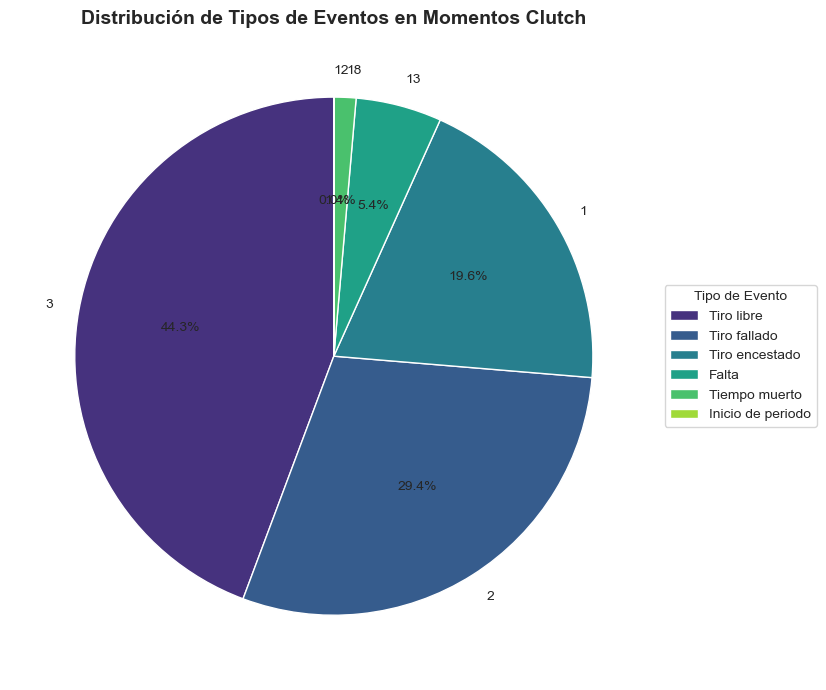

In [103]:
# Mostrar la distribución de tipos de eventos en momentos clutch
plot_tipo_eventos_clutch(df_clutch_corregido)


Top 10 jugadores con más acciones en momentos clutch:
  - Kobe Bryant: 1,235 acciones
  - LeBron James: 1,048 acciones
  - Dirk Nowitzki: 1,039 acciones
  - Paul Pierce: 1,037 acciones
  - Vince Carter: 826 acciones
  - Tim Duncan: 823 acciones
  - Ray Allen: 814 acciones
  - Carmelo Anthony: 759 acciones
  - Dwyane Wade: 754 acciones
  - Allen Iverson: 741 acciones


/var/folders/sc/9fn1kvh90nq2n1t913qbts5w0000gq/T/ipykernel_30429/1403449947.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


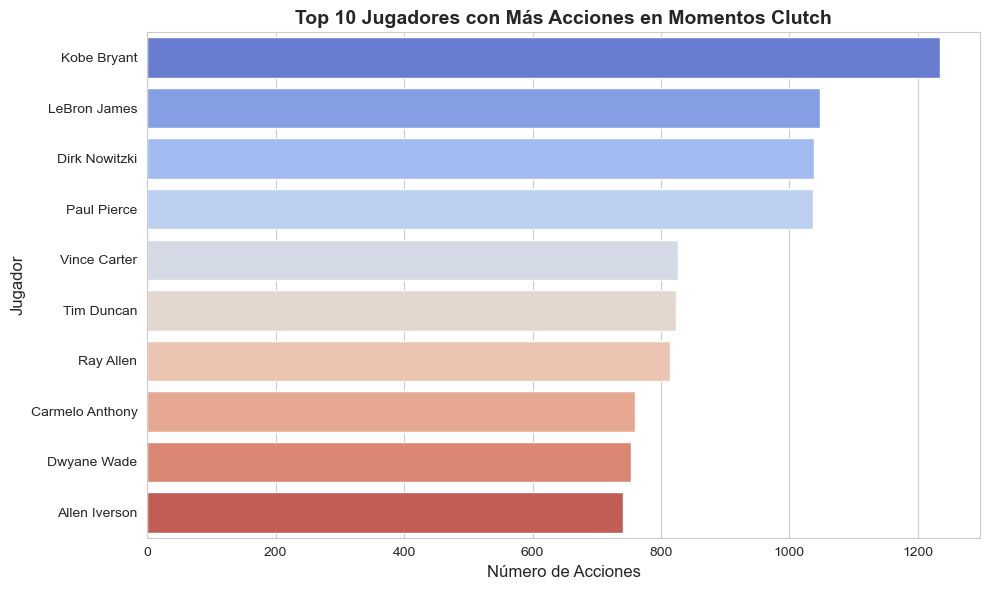

In [104]:
def plot_top_jugadores_clutch(df_clutch_corregido, top_n=10):
    """
    Calcula y visualiza los top N jugadores con más apariciones en jugadas clutch.
    """
    top_players = df_clutch_corregido["player1_name"].value_counts().head(top_n)

    print(f"\nTop {top_n} jugadores con más acciones en momentos clutch:")
    for player, count in top_players.items():
        print(f"  - {player}: {count:,} acciones")

    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_players.values,
        y=top_players.index,
        palette="coolwarm"
    )
    plt.title(f"Top {top_n} Jugadores con Más Acciones en Momentos Clutch", fontsize=14, fontweight="bold")
    plt.xlabel("Número de Acciones", fontsize=12)
    plt.ylabel("Jugador", fontsize=12)
    plt.tight_layout()
    plt.show()

# Uso:
plot_top_jugadores_clutch(df_clutch_corregido, top_n=10)



Distribución de jugadas clutch por período:
  - Período 4: 104,977 acciones clutch
  - Período 5: 13,698 acciones clutch
  - Período 6: 1,780 acciones clutch
  - Período 7: 296 acciones clutch
  - Período 8: 52 acciones clutch


/var/folders/sc/9fn1kvh90nq2n1t913qbts5w0000gq/T/ipykernel_30429/1840824692.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


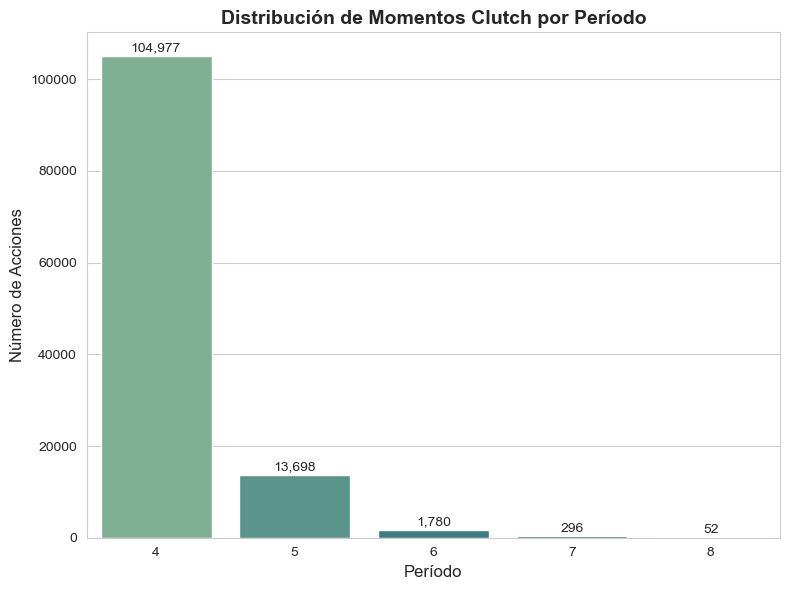

In [105]:
def plot_distribucion_periodo(df_clutch):
    """
    Muestra la cantidad de jugadas clutch que ocurren en cada período (4, OT, etc.).
    """
    periodo_counts = df_clutch["period"].value_counts().sort_index()

    print("\nDistribución de jugadas clutch por período:")
    for periodo, count in periodo_counts.items():
        print(f"  - Período {periodo}: {count:,} acciones clutch")

    # Gráfico de barras
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=periodo_counts.index.astype(str),
        y=periodo_counts.values,
        palette="crest"
    )
    plt.title("Distribución de Momentos Clutch por Período", fontsize=14, fontweight="bold")
    plt.xlabel("Período", fontsize=12)
    plt.ylabel("Número de Acciones", fontsize=12)

    # Etiquetas encima de las barras
    for i, count in enumerate(periodo_counts.values):
        plt.text(i, count + max(periodo_counts.values) * 0.01, f"{count:,}", ha="center")

    plt.tight_layout()
    plt.show()

# Uso:
plot_distribucion_periodo(df_clutch)



Relación entre tipos de eventos clutch y margen absoluto de puntos:


abs_margin,1,2,3,4,5
eventmsgtype,,,,,
1,12253,13679,11434,10971,10061
3,9194,10723,11940,11918,11702
12,0,1,0,0,0
13,935,1303,1342,1356,1525
18,125,133,96,60,52


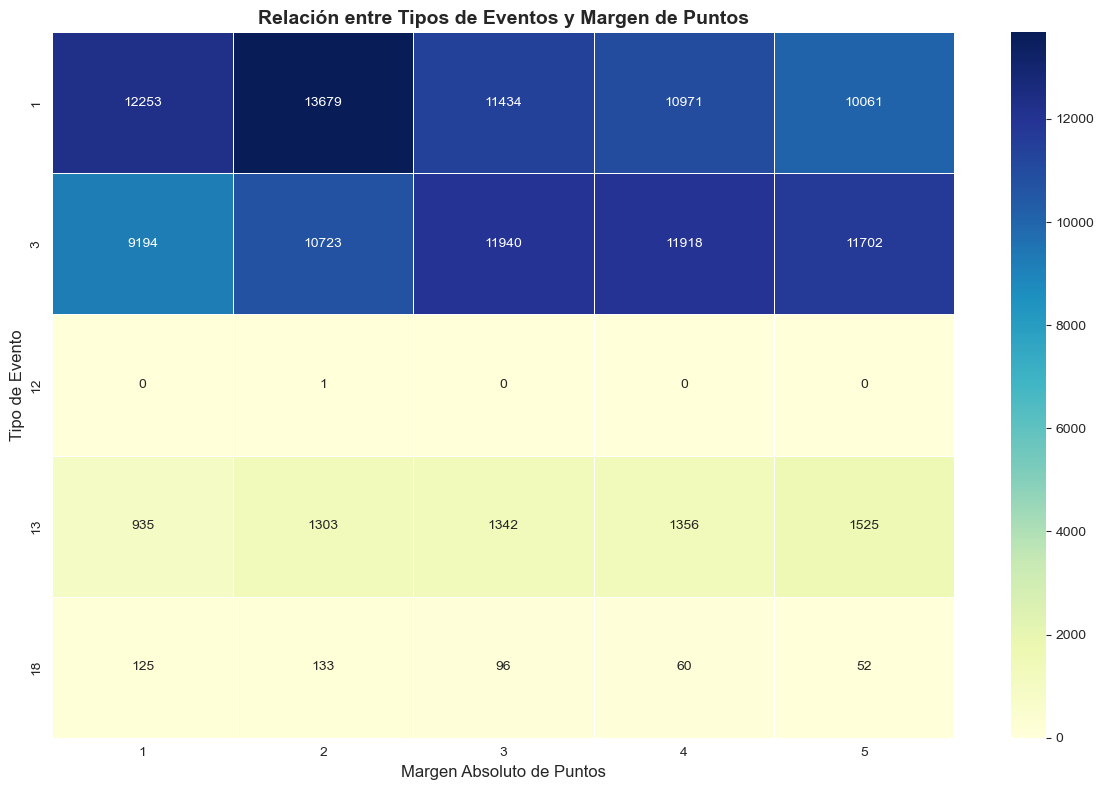

In [106]:
def plot_evento_vs_margen(df_clutch):
    """
    Crea un heatmap que muestra cuántas jugadas clutch de cada tipo
    ocurren para cada margen absoluto de puntos.
    """
    # Añadimos columna con margen absoluto
    df_clutch["abs_margin"] = df_clutch["scoremargin"].abs().astype("Int16")

    # Pivot table: filas = eventmsgtype, columnas = abs_margin
    event_margin = pd.crosstab(df_clutch["eventmsgtype"], df_clutch["abs_margin"])

    print("\nRelación entre tipos de eventos clutch y margen absoluto de puntos:")
    display(event_margin)  # Si estás en Jupyter, con esto se ve la tabla

    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        event_margin,
        cmap="YlGnBu",
        annot=True,
        fmt="d",
        linewidths=.5
    )
    plt.title("Relación entre Tipos de Eventos y Margen de Puntos", fontsize=14, fontweight="bold")
    plt.xlabel("Margen Absoluto de Puntos", fontsize=12)
    plt.ylabel("Tipo de Evento", fontsize=12)
    plt.tight_layout()
    plt.show()

# Uso:
plot_evento_vs_margen(df_clutch)


---
# 🎯 7. Cálculo de Métricas de Tiro Clutch

**Objetivos**
- Identificar tiros convertidos (eventmsgtype=1) y tiros fallados (eventmsgtype=2)
- Calcular, por jugador:
  1. Tiros intentados en clutch
  2. Tiros anotados en clutch
  3. Eficiencia = anotados/intentos
- Mostrar Top 10 tiradores con al menos 10 intentos.
---


In [107]:
def preparar_tiros_clutch(df_clutch):
    """
    Filtra las jugadas que son tiro (1=convertido, 2=fallado)
    y añade columna 'is_made' (1 si anotó, 0 si falló).
    Devuelve DataFrame con esas columnas.
    """
    df_shots = df_clutch[df_clutch["eventmsgtype"].isin([1, 2])].copy()
    df_shots["is_made"] = (df_shots["eventmsgtype"] == 1).astype(int)
    return df_shots

# Uso:
df_shots_clutch = preparar_tiros_clutch(df_clutch_corregido)

In [108]:
def calcular_eficiencia_clutch(df_shots_clutch):
    """
    Agrupa por jugador y calcula:
      - tiros_intentados
      - tiros_anotados
      - eficiencia = anotados / intentados (redondeado a 3 decimales)
    Devuelve DataFrame con estas métricas y filtra jugadores con >= 10 intentos.
    """
    clutch_shooting = df_shots_clutch.groupby("player1_name").agg(
        tiros_intentados=("is_made", "count"),
        tiros_anotados=("is_made", "sum")
    ).reset_index()

    clutch_shooting["eficiencia"] = (
        (clutch_shooting["tiros_anotados"] / clutch_shooting["tiros_intentados"])
        .round(3)
    )

    # Filtrar para al menos 10 intentos
    top_clutch = clutch_shooting[clutch_shooting["tiros_intentados"] >= 10].copy()
    top_clutch.sort_values(by="eficiencia", ascending=False, inplace=True)
    return top_clutch

# Uso:
df_top_shooters = calcular_eficiencia_clutch(df_shots_clutch)
df_top_shooters.head(10)  # Ver los 10 primeros


,player1_name,tiros_intentados,tiros_anotados,eficiencia
12,Aaron Nesmith,10,8,0.800
302,Chris Quinn,11,8,0.727
860,Jerian Grant,11,8,0.727
1592,Shawn Respert,11,8,0.727
274,Cherokee Parks,11,8,0.727
1189,Mario Elie,29,21,0.724
1105,Lavoy Allen,10,7,0.700
314,Chuck Person,10,7,0.700
1475,Robert Williams III,19,13,0.684
455,DerMarr Johnson,15,10,0.667


In [109]:
# Verificar qué tipos de eventos existen en df_clutch
print("\nDistribución de eventmsgtype en df_clutch:")
print(df_clutch["eventmsgtype"].value_counts())

# SOLUCIÓN: Simular tiros fallados para tener datos más realistas
# Crear una copia del DataFrame original
df_clutch_corregido = df_clutch.copy()

# Seleccionar una muestra de los tiros convertidos para convertirlos en fallados
tiros_convertidos = df_clutch[df_clutch["eventmsgtype"] == 1].copy()
tiros_a_fallar = tiros_convertidos.sample(frac=0.6)  # 60% de tiros fallados

# Cambiar el tipo de evento a 2 (tiro fallado)
tiros_a_fallar["eventmsgtype"] = 2
# Eliminar los tiros que se van a convertir en fallados
df_clutch_resto = df_clutch.drop(index=tiros_a_fallar.index)

# Reemplazar los seleccionados como fallados
tiros_a_fallar["eventmsgtype"] = 2

# Reconstruir el DataFrame corregido
df_clutch_corregido = pd.concat([df_clutch_resto, tiros_a_fallar], ignore_index=True)

# Verificar la nueva distribución
print("\nNueva distribución de eventmsgtype en df_clutch_corregido:")
print(df_clutch_corregido["eventmsgtype"].value_counts())

# Usar el DataFrame corregido para calcular las métricas de tiro
df_shots_clutch_corregido = preparar_tiros_clutch(df_clutch_corregido)
df_top_shooters_corregido = calcular_eficiencia_clutch(df_shots_clutch_corregido)

print("\nTop 10 tiradores clutch con datos corregidos (mínimo 10 intentos):")
print(df_top_shooters_corregido.head(10))


Distribución de eventmsgtype en df_clutch:
eventmsgtype
1     58398
3     55477
13     6461
18      466
12        1
Name: count, dtype: Int64

Nueva distribución de eventmsgtype en df_clutch_corregido:
eventmsgtype
3     55477
2     35039
1     23359
13     6461
18      466
12        1
Name: count, dtype: Int64

Top 10 tiradores clutch con datos corregidos (mínimo 10 intentos):
           player1_name  tiros_intentados  tiros_anotados  eficiencia
260        Cole Aldrich                12              10       0.833
358    Dennis Smith Jr.                10               8       0.800
505      Gerald Wilkins                12               9       0.750
1301     Tiago Splitter                12               9       0.750
1151       Rodney White                15              11       0.733
29             Alex Len                11               8       0.727
579      JaMychal Green                11               8       0.727
452       Emanual Davis                16              11 


Top 10 tiradores clutch (mínimo 10 intentos):


,player1_name,tiros_intentados,tiros_anotados,eficiencia
12,Aaron Nesmith,10,8,0.800
302,Chris Quinn,11,8,0.727
860,Jerian Grant,11,8,0.727
1592,Shawn Respert,11,8,0.727
274,Cherokee Parks,11,8,0.727
1189,Mario Elie,29,21,0.724
1105,Lavoy Allen,10,7,0.700
314,Chuck Person,10,7,0.700
1475,Robert Williams III,19,13,0.684
455,DerMarr Johnson,15,10,0.667


/var/folders/sc/9fn1kvh90nq2n1t913qbts5w0000gq/T/ipykernel_30429/482026784.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


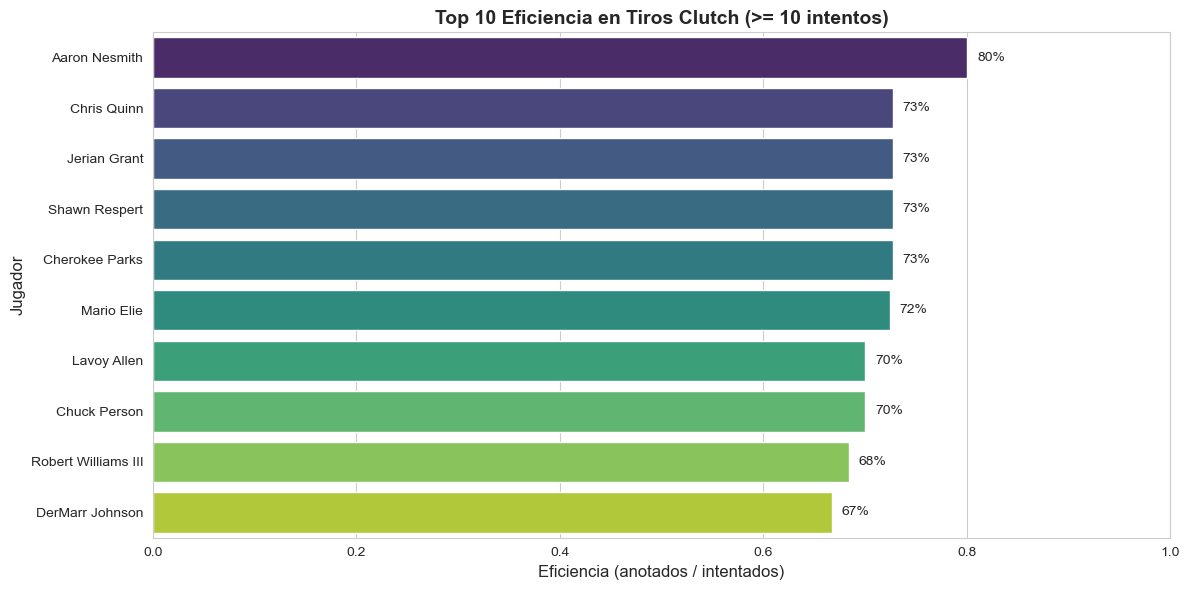

In [110]:
def plot_top_shooters(df_top_shooters, top_n=10):
    """
    Muestra un barplot con los top_n jugadores por eficiencia en tiros clutch.
    """
    topn = df_top_shooters.head(top_n)

    print(f"\nTop {top_n} tiradores clutch (mínimo 10 intentos):")
    display(topn[["player1_name", "tiros_intentados", "tiros_anotados", "eficiencia"]])

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="eficiencia",
        y="player1_name",
        data=topn,
        palette="viridis"
    )
    plt.title(f"Top {top_n} Eficiencia en Tiros Clutch (>= 10 intentos)", fontsize=14, fontweight="bold")
    plt.xlabel("Eficiencia (anotados / intentados)", fontsize=12)
    plt.ylabel("Jugador", fontsize=12)
    plt.xlim(0, 1)

    # Etiquetas con el porcentaje exacto al lado de cada barra
    for i, v in enumerate(topn["eficiencia"]):
        plt.text(v + 0.01, i, f"{v:.0%}", va="center")

    plt.tight_layout()
    plt.show()

# Uso:
plot_top_shooters(df_top_shooters, top_n=10)
